In [158]:
!apt install git
!apt install wget

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [159]:
!pip install -U pip numpy
!pip install --upgrade scikit-learn
!pip install -U scikit-learn
!pip install --upgrade sklearn

In [160]:
#Sklearn 
from sklearn.cluster import KMeans, DBSCAN
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_blobs
from sklearn_som.som import SOM

from scipy.cluster.hierarchy import fcluster
import fastcluster

import matplotlib .pyplot as plt
import pandas as pd
import seaborn as sn
import numpy as np
import genieclust
import joblib
import time
import hdbscan

## - Small dataset

In [161]:
github = "https://github.com/gagolews/clustering_benchmarks_v1/raw/master/"

dataset = "wut/labirynth" 
data_url = github + dataset + ".data.gz"
labels_url = github + dataset + ".labels0.gz"

!wget $data_url
!wget $labels_url

--2021-12-21 17:14:00--  https://github.com/gagolews/clustering_benchmarks_v1/raw/master/wut/labirynth.data.gz
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/gagolews/clustering_benchmarks_v1/master/wut/labirynth.data.gz [following]
--2021-12-21 17:14:00--  https://raw.githubusercontent.com/gagolews/clustering_benchmarks_v1/master/wut/labirynth.data.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 61583 (60K) [application/octet-stream]
Saving to: ‘labirynth.data.gz.3’

labirynth.data.gz.3 100%[===================>]  60,14K  --.-KB/s    in 0,04s   

2021-12-21 17:14:00 (1,38 MB/s) - ‘labirynth

In [162]:
# load data into a numpy array
X = np.loadtxt(dataset.split("/")[1]+".data.gz", ndmin=2)

# Load the corresponding reference labels. The original labels are in {1,2,..,k}.
# We'll make them more Python-ish by subtracting 1.
labels_true  = np.loadtxt(dataset.split("/")[1]+".labels0.gz", dtype=np.intc)-1

# The number of unique labels gives the true cluster count:
n_clusters = len(np.unique(labels_true))

In [163]:
print('The shape of X is: ', X.shape)
print('The number of clusters is: ', n_clusters)

The shape of X is:  (3546, 2)
The number of clusters is:  6


In [164]:
def plots(adjrand_scores, adjmutual_scores, v_scores, st, fin):
   
    plt.plot(range(st, fin), adjrand_scores)
    print('best adjusted rand score is {} for k : {}'.format(max(adjrand_scores), adjrand_scores.index(max(adjrand_scores))))

    plt.plot(range(st, fin), adjmutual_scores)
    print('best adjusted mutual info score is {} for k : {}'.format(max(adjmutual_scores), adjmutual_scores.index(max(adjmutual_scores))))

    plt.plot(range(st, fin), v_scores)
    print('best v-measure score is {} for k : {}'.format(max(v_scores), v_scores.index(max(v_scores))))

    plt.legend(['adjusted rand index', 'adjusted mutual information', 'v-score'], loc='lower right', prop={'size': 10})
    plt.show()

- K-means

best adjusted rand score is 0.34105916424461374 for k : 6
best adjusted mutual info score is 0.6379869542710754 for k : 16
best v-measure score is 0.6399186658262541 for k : 16


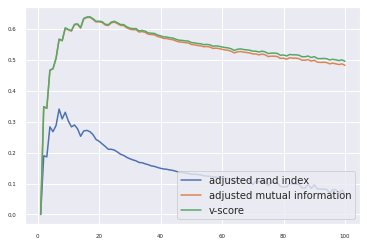

In [165]:
adjrand_scores_knn = []
adjmutual_scores_knn = []
v_scores_knn = []
for k in range(1, 101):
    km = KMeans(k, random_state = 99).fit(X)
    adjrand_scores_knn.append(metrics.adjusted_rand_score(km.labels_, labels_true))
    adjmutual_scores_knn.append(metrics.adjusted_mutual_info_score(km.labels_, labels_true))
    v_scores_knn.append(metrics.v_measure_score(km.labels_, labels_true))
    
plots(adjrand_scores_knn, adjmutual_scores_knn, v_scores_knn, 1, 101)

knn adjusted rand score for 6 clusters is : 0.28774748417147067 
knn adjusted mutual information score for 6 clusters is : 0.504291370303364 
knn v-measure score for 6 clusters is : 0.5053680248632945 


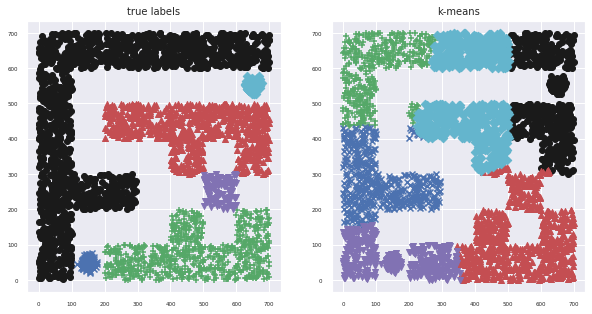

In [166]:
km = KMeans(n_clusters, random_state = 99).fit(X)

f, axs = plt.subplots(2,2,figsize=(10,5))
plt.subplot(121)
plt.title("true labels", fontsize=10)
genieclust.plots.plot_scatter(X, labels = labels_true)


plt.subplot(122)
plt.title("k-means", fontsize=10)
genieclust.plots.plot_scatter(X, labels= km.labels_)

print('knn adjusted rand score for {} clusters is : {} ' .format(n_clusters, metrics.adjusted_rand_score(km.labels_, labels_true)))
print('knn adjusted mutual information score for {} clusters is : {} ' .format(n_clusters, metrics.adjusted_mutual_info_score(km.labels_, labels_true)))
print('knn v-measure score for {} clusters is : {} ' .format(n_clusters, metrics.v_measure_score(km.labels_, labels_true)))

- HAC 

In [167]:
#single link
adjrand_scores_single = []
adjmutual_scores_single = []
v_scores_single = []

#average link
adjrand_scores_avg = []
adjmutual_scores_avg = []
v_scores_avg = []

#complete link
adjrand_scores_com = []
adjmutual_scores_com = []
v_scores_com = []

#ward link
adjrand_scores_ward = []
adjmutual_scores_ward = []
v_scores_ward = []

for k in range(1, 101):
    #single link
    hac_single = fastcluster.linkage(X, method = 'single')
    hac_labels_single =  fcluster(hac_single, k, criterion='maxclust')
    adjrand_scores_single.append(metrics.adjusted_rand_score(hac_labels_single-1, labels_true))
    adjmutual_scores_single.append(metrics.adjusted_mutual_info_score(hac_labels_single-1, labels_true))
    v_scores_single.append(metrics.v_measure_score(hac_labels_single-1, labels_true))
    
    #average link
    hac_avg = fastcluster.linkage(X, method = 'average')
    hac_labels_avg =  fcluster(hac_avg, k, criterion='maxclust')
    adjrand_scores_avg.append(metrics.adjusted_rand_score(hac_labels_avg-1, labels_true))
    adjmutual_scores_avg.append(metrics.adjusted_mutual_info_score(hac_labels_avg-1, labels_true))
    v_scores_avg.append(metrics.v_measure_score(hac_labels_avg-1, labels_true))
    
    #complete link
    hac_com = fastcluster.linkage(X, method = 'complete')
    hac_labels_com =  fcluster(hac_com, k, criterion='maxclust')
    adjrand_scores_com.append(metrics.adjusted_rand_score(hac_labels_com-1, labels_true))
    adjmutual_scores_com.append(metrics.adjusted_mutual_info_score(hac_labels_com-1, labels_true))
    v_scores_com.append(metrics.v_measure_score(hac_labels_com-1, labels_true))
    
    
    #ward link
    hac_ward = fastcluster.linkage(X, method = 'ward')
    hac_labels_ward =  fcluster(hac_ward, k, criterion='maxclust')
    adjrand_scores_ward.append(metrics.adjusted_rand_score(hac_labels_ward-1, labels_true))
    adjmutual_scores_ward.append(metrics.adjusted_mutual_info_score(hac_labels_ward-1, labels_true))
    v_scores_ward.append(metrics.v_measure_score(hac_labels_ward-1, labels_true))

Single link
best adjusted rand score is 0.9476723455751217 for k : 12
best adjusted mutual info score is 0.9454630230689187 for k : 12
best v-measure score is 0.9457347638576877 for k : 12


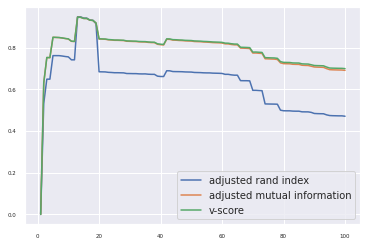


Average link
best adjusted rand score is 0.3556401324039843 for k : 5
best adjusted mutual info score is 0.6647765310427755 for k : 12
best v-measure score is 0.6662153073892937 for k : 12


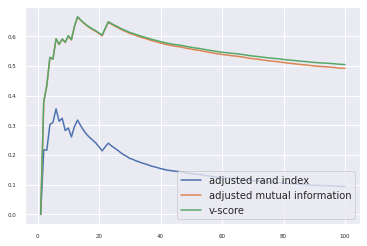


Complete link
best adjusted rand score is 0.3356917357616256 for k : 10
best adjusted mutual info score is 0.6573397261620771 for k : 10
best v-measure score is 0.6586076152527152 for k : 10


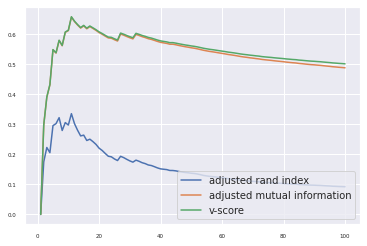


Ward link
best adjusted rand score is 0.39810970868368495 for k : 7
best adjusted mutual info score is 0.6903781213140812 for k : 16
best v-measure score is 0.692044323250397 for k : 16


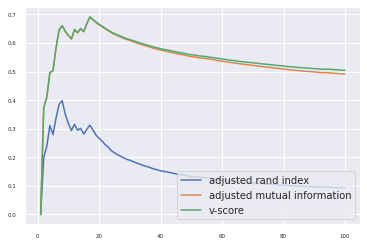

In [168]:
print('Single link')
plots(adjrand_scores_single, adjmutual_scores_single, v_scores_single, 1, 101)

print()
print('Average link')
plots(adjrand_scores_avg, adjmutual_scores_avg, v_scores_avg, 1, 101)

print()
print('Complete link')
plots(adjrand_scores_com, adjmutual_scores_com, v_scores_com, 1, 101)

print()
print('Ward link')
plots(adjrand_scores_ward, adjmutual_scores_ward, v_scores_ward, 1, 101)

-hac signle linking

hac adjusted rand score for 6 clusters is : 0.7612091527137739 
hac adjusted mutual information score for 6 clusters is : 0.8483783010594431 
hac v-measure score for 6 clusters is : 0.8487259077930347 

-hac average linking

hac adjusted rand score for 6 clusters is : 0.3556401324039843 
hac adjusted mutual information score for 6 clusters is : 0.5912115031708534 
hac v-measure score for 6 clusters is : 0.592108338029607 

-hac complete linking

hac adjusted rand score for 6 clusters is : 0.3025874314520412 
hac adjusted mutual information score for 6 clusters is : 0.5376031210533728 
hac v-measure score for 6 clusters is : 0.538607279154998 

-hac ward linking

hac adjusted rand score for 6 clusters is : 0.3376866862069267 
hac adjusted mutual information score for 6 clusters is : 0.5824245973673748 
hac v-measure score for 6 clusters is : 0.5833437604408647 


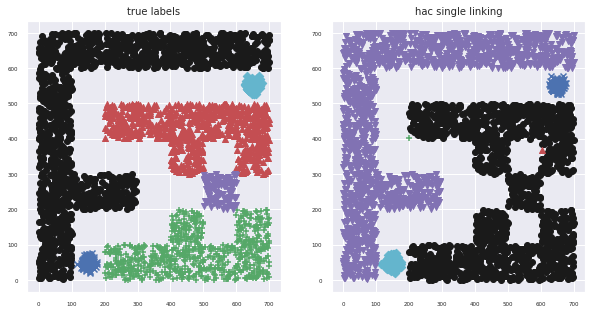

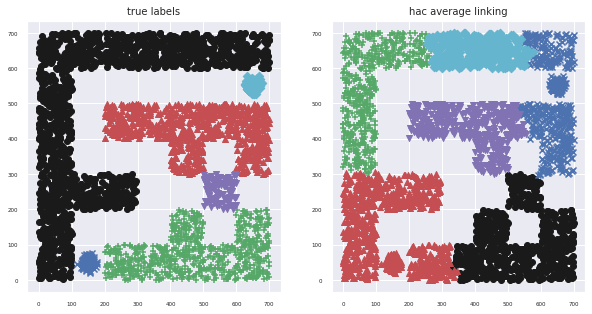

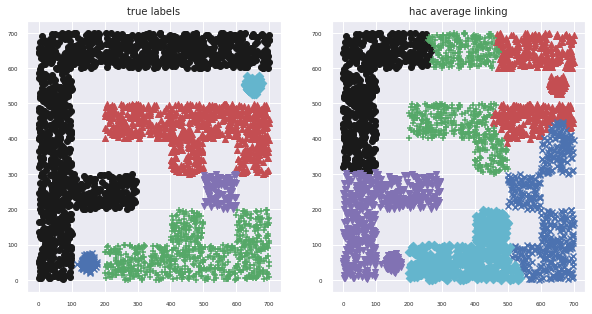

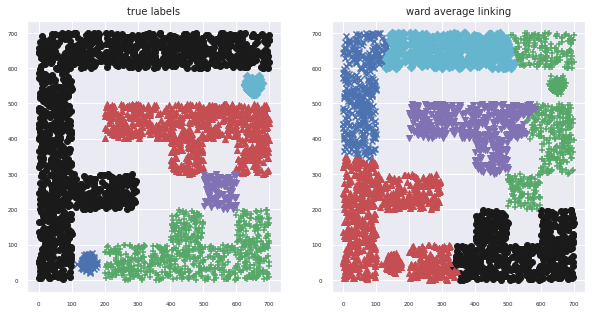

In [169]:
#single
hac_single = fastcluster.linkage(X, method = 'single')
hac_labels_single =  fcluster(hac_single, n_clusters, criterion='maxclust')-1

f, axs = plt.subplots(2,2,figsize=(10,5))

plt.subplot(121)
plt.title("true labels", fontsize=10)
genieclust.plots.plot_scatter(X, labels = labels_true)

plt.subplot(122)
plt.title("hac single linking", fontsize=10)
genieclust.plots.plot_scatter(X, labels= hac_labels_single)

print('-hac signle linking')
print()
print('hac adjusted rand score for {} clusters is : {} ' .format(n_clusters, metrics.adjusted_rand_score(hac_labels_single, labels_true)))
print('hac adjusted mutual information score for {} clusters is : {} ' .format(n_clusters, metrics.adjusted_mutual_info_score(hac_labels_single, labels_true)))
print('hac v-measure score for {} clusters is : {} ' .format(n_clusters, metrics.v_measure_score(hac_labels_single, labels_true)))

#average
hac_avg = fastcluster.linkage(X, method = 'average')
hac_labels_avg =  fcluster(hac_avg, n_clusters, criterion='maxclust')-1

f, axs = plt.subplots(2,2,figsize=(10,5))

plt.subplot(121)
plt.title("true labels", fontsize=10)
genieclust.plots.plot_scatter(X, labels = labels_true)

plt.subplot(122)
plt.title("hac average linking", fontsize=10)
genieclust.plots.plot_scatter(X, labels= hac_labels_avg)
print()

print('-hac average linking')
print()
print('hac adjusted rand score for {} clusters is : {} ' .format(n_clusters, metrics.adjusted_rand_score(hac_labels_avg, labels_true)))
print('hac adjusted mutual information score for {} clusters is : {} ' .format(n_clusters, metrics.adjusted_mutual_info_score(hac_labels_avg, labels_true)))
print('hac v-measure score for {} clusters is : {} ' .format(n_clusters, metrics.v_measure_score(hac_labels_avg, labels_true)))

#complete
hac_com = fastcluster.linkage(X, method = 'complete')
hac_labels_com =  fcluster(hac_com, n_clusters, criterion='maxclust')-1

f, axs = plt.subplots(2,2,figsize=(10,5))

plt.subplot(121)
plt.title("true labels", fontsize=10)
genieclust.plots.plot_scatter(X, labels = labels_true)

plt.subplot(122)
plt.title("hac average linking", fontsize=10)
genieclust.plots.plot_scatter(X, labels= hac_labels_com)
print()

print('-hac complete linking')
print()
print('hac adjusted rand score for {} clusters is : {} ' .format(n_clusters, metrics.adjusted_rand_score(hac_labels_com, labels_true)))
print('hac adjusted mutual information score for {} clusters is : {} ' .format(n_clusters, metrics.adjusted_mutual_info_score(hac_labels_com, labels_true)))
print('hac v-measure score for {} clusters is : {} ' .format(n_clusters, metrics.v_measure_score(hac_labels_com, labels_true)))

#ward
hac_ward = fastcluster.linkage(X, method = 'ward')
hac_labels_ward =  fcluster(hac_ward, n_clusters, criterion='maxclust')-1

f, axs = plt.subplots(2,2,figsize=(10,5))

plt.subplot(121)
plt.title("true labels", fontsize=10)
genieclust.plots.plot_scatter(X, labels = labels_true)

plt.subplot(122)
plt.title("ward average linking", fontsize=10)
genieclust.plots.plot_scatter(X, labels= hac_labels_ward)
print()

print('-hac ward linking')
print()
print('hac adjusted rand score for {} clusters is : {} ' .format(n_clusters, metrics.adjusted_rand_score(hac_labels_ward, labels_true)))
print('hac adjusted mutual information score for {} clusters is : {} ' .format(n_clusters, metrics.adjusted_mutual_info_score(hac_labels_ward, labels_true)))
print('hac v-measure score for {} clusters is : {} ' .format(n_clusters, metrics.v_measure_score(hac_labels_ward, labels_true)))

- GMM

best adjusted rand score is 0.5152802064234441 for k : 6
best adjusted mutual info score is 0.7467532788631174 for k : 8
best v-measure score is 0.7475562936239224 for k : 8


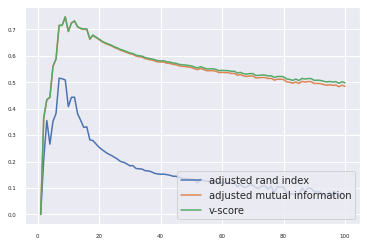

In [170]:
adjrand_scores_gmm = []
adjmutual_scores_gmm = []
v_scores_gmm = []
for k in range(1, 101):
    gmm = GaussianMixture(n_components = k).fit(X)
    gmm_labels = gmm.predict(X)
    adjrand_scores_gmm.append(metrics.adjusted_rand_score(gmm_labels, labels_true))
    adjmutual_scores_gmm.append(metrics.adjusted_mutual_info_score(gmm_labels, labels_true))
    v_scores_gmm.append(metrics.v_measure_score(gmm_labels, labels_true))
    
plots(adjrand_scores_gmm, adjmutual_scores_gmm, v_scores_gmm,1, 101)

gmm adjusted rand score for 6 clusters is : 0.6114059595016926 
gmm adjusted mutual information score for 6 clusters is : 0.7895910988894899 
gmm v-measure score for 6 clusters is : 0.7900533482460971 


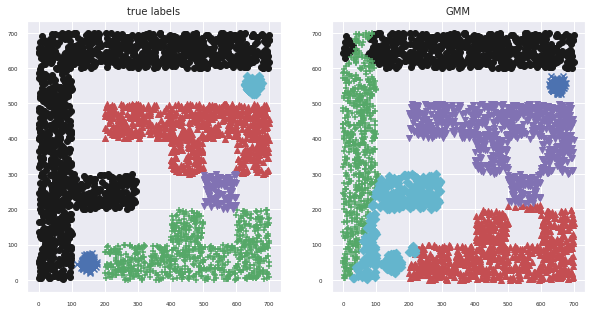

In [171]:
gmm = GaussianMixture(n_components = n_clusters).fit(X)
gmm_labels = gmm.predict(X)
f, axs = plt.subplots(2,2,figsize=(10,5))
plt.subplot(121)
plt.title("true labels", fontsize=10)
genieclust.plots.plot_scatter(X, labels = labels_true)


plt.subplot(122)
plt.title("GMM", fontsize=10)
genieclust.plots.plot_scatter(X, labels= gmm_labels)

print('gmm adjusted rand score for {} clusters is : {} ' .format(n_clusters, metrics.adjusted_rand_score(gmm_labels, labels_true)))
print('gmm adjusted mutual information score for {} clusters is : {} ' .format(n_clusters, metrics.adjusted_mutual_info_score(gmm_labels, labels_true)))
print('gmm v-measure score for {} clusters is : {} ' .format(n_clusters, metrics.v_measure_score(gmm_labels, labels_true)))

- DBSCAN

adjusted rand score is 0.0
adjusted mutual score is 2.635640005469989e-16
v-measure score is 0.0


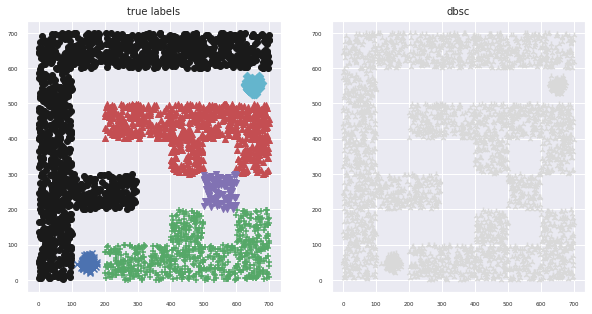

In [172]:
dbscan = DBSCAN().fit(X)
dbsc_labels = dbscan.labels_
print('adjusted rand score is', metrics.adjusted_rand_score(dbsc_labels, labels_true))
print('adjusted mutual score is', metrics.adjusted_mutual_info_score(dbsc_labels, labels_true))
print('v-measure score is', metrics.v_measure_score(dbsc_labels, labels_true))

f, axs = plt.subplots(2,2,figsize=(10,5))
plt.subplot(121)
plt.title("true labels", fontsize=10)
genieclust.plots.plot_scatter(X, labels = labels_true)

plt.subplot(122)
plt.title("dbsc", fontsize=10)
genieclust.plots.plot_scatter(X, labels= dbsc_labels)

The scores are practically zero and nothing is clusterd so we will try the model for different parameters

best adjusted rand score is 0.020385366606730744 for k : 1
best adjusted mutual info score is 0.04200922603092157 for k : 1
best v-measure score is 0.30864367847174473 for k : 0


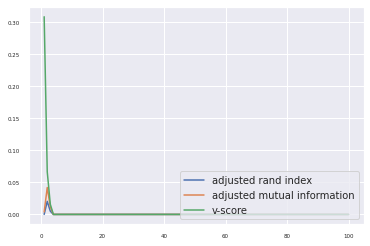

We achieve 6 clusters for values of min samples : []


In [173]:
adjrand_scores_dbsc = []
adjmutual_scores_dbsc = []
v_scores_dbsc = []
k_list = []

for k in range(1, 101):
    dbscan = DBSCAN(eps = .5, min_samples = k).fit(X)
    dbsc_labels = dbscan.labels_
    adjrand_scores_dbsc.append(metrics.adjusted_rand_score(dbsc_labels, labels_true))
    adjmutual_scores_dbsc.append(metrics.adjusted_mutual_info_score(dbsc_labels, labels_true))
    v_scores_dbsc.append(metrics.v_measure_score(dbsc_labels, labels_true))
    if(max(dbsc_labels) == max(labels_true)) : k_list.append(k)

plots(adjrand_scores_dbsc, adjmutual_scores_dbsc, v_scores_dbsc,1, 101)
print('We achieve {} clusters for values of min samples : {}' .format(n_clusters, k_list))

The performance is not so good so we will try different e and min_samples values and we see that we dont achieve 6 clusters in our model for the default epsilon value (.5) at all.

We observe that for the default value of e which is the maximum distance between two samples combined with k = min_samples which is the number of samples (or total weight) in a neighborhood for a point to be considered as a core point in range of (1, 100) of the algorithm doesnt have such a good performance so we try the algorithm for different e values

In [174]:
kk = []
ee = []
adjrand_scores = []
adjmutual_scores = []
v_scores = []
for k in range(1,101):
    for e in range(1,101):
        dbsc = DBSCAN(eps = e, min_samples = k).fit(X)
        dbsc_labels = dbsc.labels_
        if(max(dbsc_labels) == max(dbsc_labels)):
            adjrand_scores.append(metrics.adjusted_rand_score(dbsc_labels, labels_true))
            adjmutual_scores.append(metrics.adjusted_mutual_info_score(dbsc_labels, labels_true))
            v_scores.append(metrics.v_measure_score(dbsc_labels, labels_true))
            ee.append(e)
            kk.append(k)
         
print('best adjusted rand score is {} for e: {} and k: {}'.format(max(adjrand_scores), ee[adjrand_scores.index(max(adjrand_scores))], kk[adjrand_scores.index(max(adjrand_scores))]))
print('best adjusted mutual score is {} for e: {} and k: {}'.format(max(adjmutual_scores), ee[adjmutual_scores.index(max(adjmutual_scores))], kk[adjmutual_scores.index(max(adjmutual_scores))]))
print('best v-measure score is {} for e: {} and k: {}'.format(max(v_scores), ee[v_scores.index(max(v_scores))], kk[v_scores.index(max(v_scores))]))

      

best adjusted rand score is 0.9954566277659768 for e: 17 and k: 5
best adjusted mutual score is 0.9892151571773773 for e: 17 and k: 5
best v-measure score is 0.9892463629225824 for e: 17 and k: 5


We observe that for the distance of e=17 and k=5 the algorithm achieves great performances

We will try the values we calculated above to visualize the labyrinth

dbsc adjusted rand score for 6 clusters is : 0.9954566277659768 
dbsc adjusted mutual information score for 6 clusters is : 0.9892151571773773 
dbsc v-measure score for 6 clusters is : 0.9892463629225824 


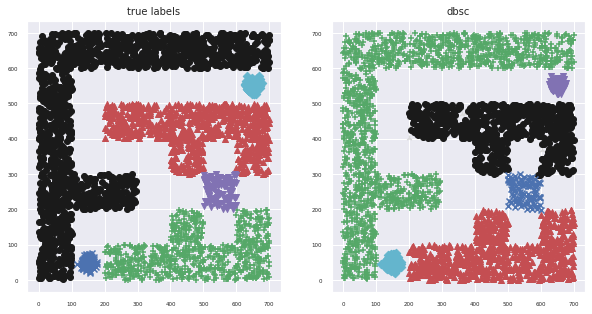

In [175]:
dbsc = DBSCAN(eps = 17, min_samples = 5).fit(X)
dbsc_labels = dbsc.labels_
f, axs = plt.subplots(2,2,figsize=(10,5))
plt.subplot(121)
plt.title("true labels", fontsize=10)
genieclust.plots.plot_scatter(X, labels = labels_true)

plt.subplot(122)
plt.title("dbsc", fontsize=10)
genieclust.plots.plot_scatter(X, labels= dbsc_labels)

print('dbsc adjusted rand score for {} clusters is : {} ' .format(n_clusters, metrics.adjusted_rand_score(dbsc_labels, labels_true)))
print('dbsc adjusted mutual information score for {} clusters is : {} ' .format(n_clusters, metrics.adjusted_mutual_info_score(dbsc_labels, labels_true)))
print('dbsc v-measure score for {} clusters is : {} ' .format(n_clusters, metrics.v_measure_score(dbsc_labels, labels_true)))

- hdbscan

adjusted rand score is 0.29709428649814573
adjusted mutual info score is 0.5683688480968795
v-measure score is 0.5767293118487814


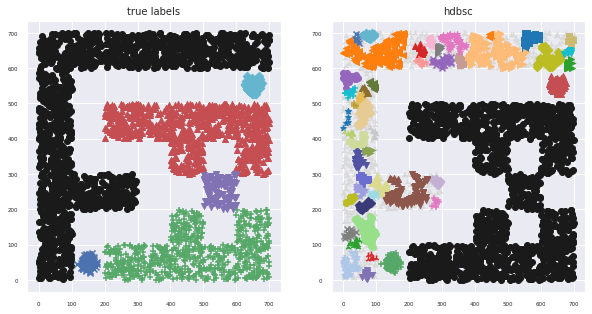

In [176]:
hdbscn = hdbscan.HDBSCAN()
hdbsc_labels = hdbscn.fit_predict(X)
print('adjusted rand score is', metrics.adjusted_rand_score(hdbsc_labels, labels_true))
print('adjusted mutual info score is', metrics.adjusted_mutual_info_score(hdbsc_labels, labels_true))
print('v-measure score is', metrics.v_measure_score(hdbsc_labels, labels_true))

f, axs = plt.subplots(2,2,figsize=(10,5))
plt.subplot(121)
plt.title("true labels", fontsize=10)
genieclust.plots.plot_scatter(X, labels = labels_true)


plt.subplot(122)
plt.title("hdbsc", fontsize=10)
genieclust.plots.plot_scatter(X, labels= hdbsc_labels)

In [177]:
print('The above scores are achieved by the model for {} clusters' .format(max(hdbsc_labels)))

The above scores are achieved by the model for 48 clusters


The model achieves the above score by adding more than 6 clusters

We will try for different cluster sizes and check for what cluster size we achieve the number of 6 clusters

best adjusted rand score is 0.5139989487635642 for k : 13
best adjusted mutual info score is 0.7277956938958547 for k : 10
best v-measure score is 0.7291114076298992 for k : 10


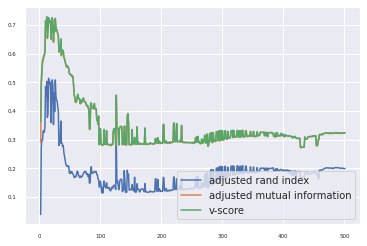

We achieve 6 clusters for values of min samples : [57, 58, 59, 60, 62, 69, 72, 79]


In [178]:
adjrand_scores_hdbsc = []
adjmutual_scores_hdbsc = []
v_scores_hdbsc = []
k_list = []
for k in range(2, 502):
    hdbscn = hdbscan.HDBSCAN(min_cluster_size=k)
    hdbsc_labels = hdbscn.fit_predict(X)
    adjrand_scores_hdbsc.append(metrics.adjusted_rand_score(hdbsc_labels, labels_true))
    adjmutual_scores_hdbsc.append(metrics.adjusted_mutual_info_score(hdbsc_labels, labels_true))
    v_scores_hdbsc.append(metrics.v_measure_score(hdbsc_labels, labels_true))
    if (max(labels_true) == max(hdbsc_labels)) : k_list.append(k)
plots(adjrand_scores_hdbsc, adjmutual_scores_hdbsc, v_scores_hdbsc, 2, 502)
print('We achieve {} clusters for values of min samples : {}' .format(n_clusters, k_list))


We see that for different cluster sizes the rand score is generally low. For the minimum cluser size values we achieve 6 clusters so we check the scores for these values of cluster size.

for cluster size : 57
hdbsc adjusted rand score for 6 clusters is : 0.1672233036708169 
hdbsc adjusted mutual information score for 6 clusters is : 0.4546549385720996 
hdbsc v-measure score for 6 clusters is : 0.45635877147904563 

for cluster size : 58
hdbsc adjusted rand score for 6 clusters is : 0.17062087370978476 
hdbsc adjusted mutual information score for 6 clusters is : 0.4471079281669613 
hdbsc v-measure score for 6 clusters is : 0.44887546656659805 

for cluster size : 59
hdbsc adjusted rand score for 6 clusters is : 0.17065286847357453 
hdbsc adjusted mutual information score for 6 clusters is : 0.4299505641820226 
hdbsc v-measure score for 6 clusters is : 0.4316975916158547 

for cluster size : 60
hdbsc adjusted rand score for 6 clusters is : 0.1701449895826905 
hdbsc adjusted mutual information score for 6 clusters is : 0.42954614857999956 
hdbsc v-measure score for 6 clusters is : 0.4313204721162174 

for cluster size : 62
hdbsc adjusted rand score for 6 clusters is : 0.1

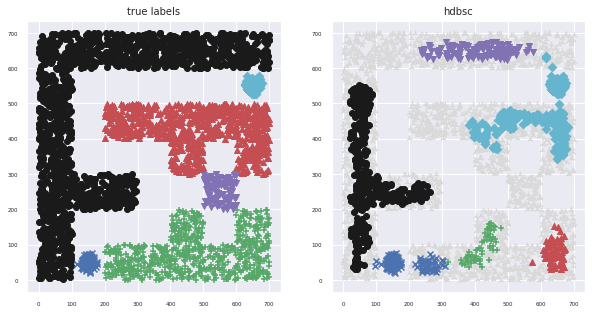

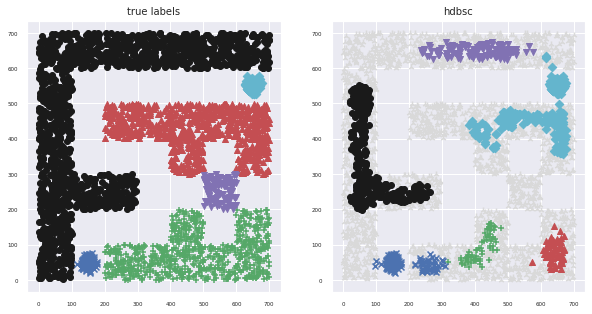

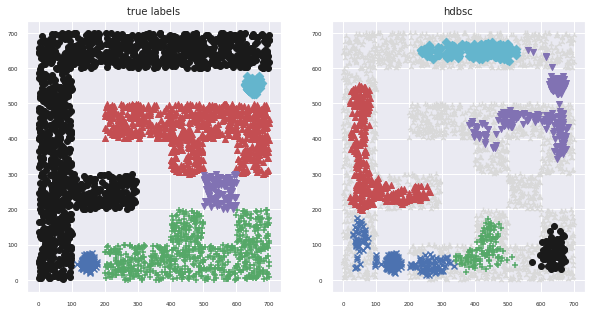

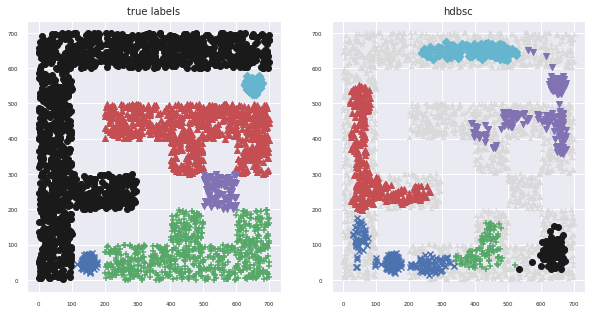

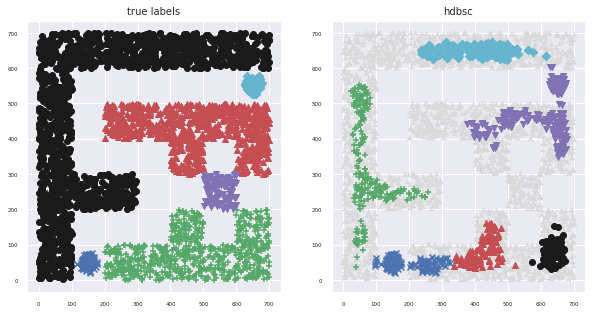

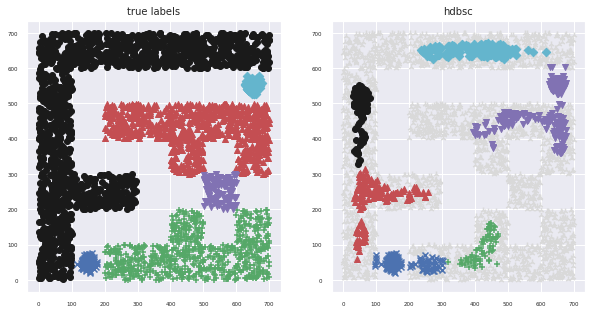

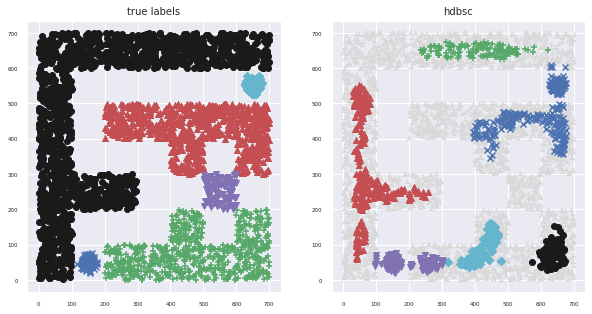

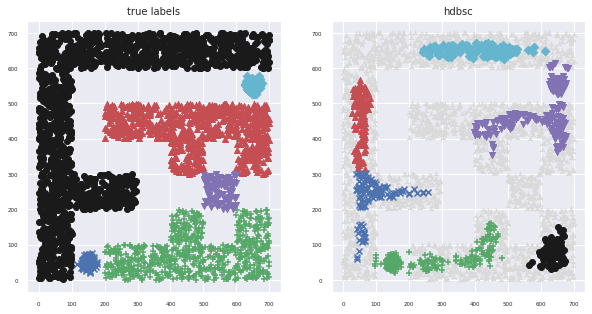

In [179]:
for k in k_list:
    hdbscn = hdbscan.HDBSCAN(min_cluster_size = k)
    hdbsc_labels = hdbscn.fit_predict(X)
    f, axs = plt.subplots(2,2,figsize=(10,5))
    plt.subplot(121)
    plt.title("true labels", fontsize=10)
    genieclust.plots.plot_scatter(X, labels = labels_true)


    plt.subplot(122)
    plt.title("hdbsc", fontsize=10)
    genieclust.plots.plot_scatter(X, labels= hdbsc_labels)

    print('for cluster size : {}' .format(k))
    print('hdbsc adjusted rand score for {} clusters is : {} ' .format(n_clusters, metrics.adjusted_rand_score(hdbsc_labels, labels_true)))
    print('hdbsc adjusted mutual information score for {} clusters is : {} ' .format(n_clusters, metrics.adjusted_mutual_info_score(hdbsc_labels, labels_true)))
    print('hdbsc v-measure score for {} clusters is : {} ' .format(n_clusters, metrics.v_measure_score(hdbsc_labels, labels_true)))
    print()

This model achieves 6 clusters but the score differs from the best achieved in which the hdbsc algorithm created 48 clusters

- SOM

best adjusted rand score is 0.3196917783419379 for k : 6
best adjusted mutual info score is 0.6106033221313187 for k : 23
best v-measure score is 0.613404698889494 for k : 23


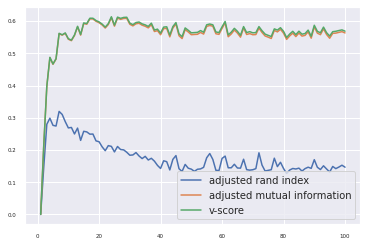

In [183]:
adjrand_scores_som = []
adjmutual_scores_som = []
v_scores_som = []
for k in range(1, 101):
    som = SOM(m=k, n=1, dim=2)
    som.fit(X)
    som_labels = som.predict(X)
    adjrand_scores_som.append(metrics.adjusted_rand_score(som_labels, labels_true))
    adjmutual_scores_som.append(metrics.adjusted_mutual_info_score(som_labels, labels_true))
    v_scores_som.append(metrics.v_measure_score(som_labels, labels_true))
    
plots(adjrand_scores_som, adjmutual_scores_som, v_scores_som, 1, 101)

som adjusted rand score for 6 clusters is : 0.27782832867189555 
som adjusted mutual information score for 6 clusters is : 0.487781926966881 
som v-measure score for 6 clusters is : 0.4888988902735733 


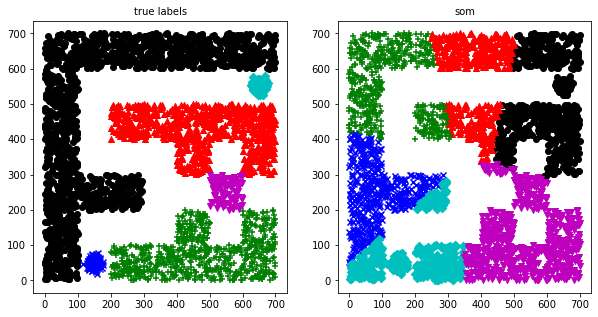

In [ ]:
som = SOM(m=n_clusters, n=1, dim=2)
som.fit(X)
som_labels = som.predict(X)
f, axs = plt.subplots(2,2,figsize=(10,5))
plt.subplot(121)
plt.title("true labels", fontsize=10)
genieclust.plots.plot_scatter(X, labels=labels_true)


plt.subplot(122)
plt.title("som", fontsize=10)
genieclust.plots.plot_scatter(X, labels=som_labels)

print('som adjusted rand score for {} clusters is : {} ' .format(n_clusters, metrics.adjusted_rand_score(som_labels, labels_true)))
print('som adjusted mutual information score for {} clusters is : {} ' .format(n_clusters, metrics.adjusted_mutual_info_score(som_labels, labels_true)))
print('som v-measure score for {} clusters is : {} ' .format(n_clusters, metrics.v_measure_score(som_labels, labels_true)))

- Markdown table

|                | Adjusted Rand Index | Adjusted Mutual Information | V-measure |
|----------------|---------------------|-----------------------------|-----------|
| K-Means        | 0.28774748417147067              | 0.504291370303364                      | 0.5053680248632945    |
| HAC 'Single'   | 0.7612091527137739              | 0.8483783010594431                      | 0.8487259077930347    |
| HAC 'Average'  | 0.3556401324039843              | 0.5912115031708534                       | 0.592108338029607    |
| HAC 'Complete' | 0.3025874314520412              | 0.5376031210533728                      | 0.538607279154998    |
| HAC 'Ward'     | 0.3376866862069267              | 0.5824245973673748                      | 0.5833437604408647    |
| GMM            | 0.6114059595016926              | 0.7895910988894899                      | 0.7900533482460971    |
| DBSCAN         | 0.9954566277659768              | 0.9892151571773773                  | 0.9892463629225824   |
| HDBSCAN        | 0.29709428649814573              | 0.5683688480968795                      | 0.5767293118487814    |
| SOM            | 0.27782832867189555              | 0.487781926966881                      | 0.4888988902735733    |

- Confusion Matrix for best score of clustering algorithm : HAC 'Single' (we dont choose the DBSCAN cause the default parameters led to 0 scores in clustering)

-hac signle linking

hac adjusted rand score for 6 clusters is : 0.7612091527137739 
hac adjusted mutual information score for 6 clusters is : 0.8483783010594431 
hac v-measure score for 6 clusters is : 0.8487259077930347 
[[0.         0.46692607 0.46627756 0.         0.         0.06679637]
 [0.         1.         0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         1.         0.        ]
 [0.         0.         0.         1.         0.         0.        ]
 [1.         0.         0.         0.         0.         0.        ]]


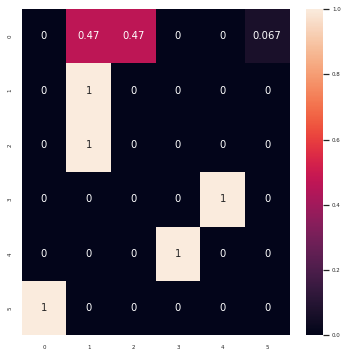

In [197]:
hac_single = fastcluster.linkage(X, method = 'single')
hac_labels_single =  fcluster(hac_single, n_clusters, criterion='maxclust') - 1 

print('-hac signle linking')
print()
print('hac adjusted rand score for {} clusters is : {} ' .format(n_clusters, metrics.adjusted_rand_score(hac_labels_single, labels_true)))
print('hac adjusted mutual information score for {} clusters is : {} ' .format(n_clusters, metrics.adjusted_mutual_info_score(hac_labels_single, labels_true)))
print('hac v-measure score for {} clusters is : {} ' .format(n_clusters, metrics.v_measure_score(hac_labels_single, labels_true)))

#average
cm = confusion_matrix(hac_labels_single, labels_true, normalize = 'true') 
#cm = cm.astype('float') / cm.sum(axis=0)[:, np.newaxis]
print(cm)

df_cm = pd.DataFrame(cm, range(6), range(6))
plt.figure(figsize=(6,6))
sn.set(font_scale=0.5) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}) # font size
plt.show()

- Confusion Matrix for worst score of clustering algorithm : SOM

[[0.45597105 0.2424608  0.         0.         0.30156815 0.        ]
 [0.         0.8215103  0.01601831 0.         0.         0.1624714 ]
 [0.         0.         0.94275492 0.         0.         0.05724508]
 [0.16984733 0.         0.35305344 0.47709924 0.         0.        ]
 [1.         0.         0.         0.         0.         0.        ]
 [0.77747253 0.22252747 0.         0.         0.         0.        ]]


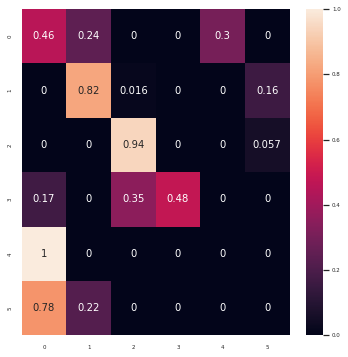

In [199]:
som = SOM(m=n_clusters, n=1, dim=2)
som.fit(X)
som_labels = som.predict(X)

cm = confusion_matrix(som_labels, labels_true, normalize = 'true') 
#cm = cm.astype('float') / cm.sum(axis=0)[:, np.newaxis]
print(cm)

df_cm = pd.DataFrame(cm, range(6), range(6))
plt.figure(figsize=(6,6))
sn.set(font_scale=0.5) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}) # font size
plt.show()

Due to the dataset which has a labyrinth form we see that K-means and HAC with average linking do not have a good performance. GMM reacts generally well with the knowledge of the clusters. The best performance is achieved in DBSCAN after some searching of the best parameters. The worst clustering takes place in SOM algorithm, due to its way of clustering and its simplicity which uses a self organizing map with a planar (rectangular) topology and is used for clustering data and performing dimensionality reduction, which doesnt help in this dataset form. Throughout the above analysis we checked the best performances after some parameter searching and we could easily conclude in HAC with 'single' linking or DBSCAN for this dataset.

## -Big dataset

In [201]:
github = "https://github.com/gagolews/clustering_benchmarks_v1/raw/master/"

dataset = "h2mg/h2mg_128_90" 
data_url = github + dataset + ".data.gz"
labels_url = github + dataset + ".labels0.gz"

!wget $data_url
!wget $labels_url

--2021-12-21 17:59:18--  https://github.com/gagolews/clustering_benchmarks_v1/raw/master/h2mg/h2mg_128_90.data.gz
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/gagolews/clustering_benchmarks_v1/master/h2mg/h2mg_128_90.data.gz [following]
--2021-12-21 17:59:19--  https://raw.githubusercontent.com/gagolews/clustering_benchmarks_v1/master/h2mg/h2mg_128_90.data.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 497217 (486K) [application/octet-stream]
Saving to: ‘h2mg_128_90.data.gz.1’

h2mg_128_90.data.gz 100%[===================>] 485,56K  2,99MB/s    in 0,2s    

2021-12-21 17:59:19 (2,99 MB/s)

In [202]:
# load data into a numpy array
X = np.loadtxt(dataset.split("/")[1]+".data.gz", ndmin=2)

# Load the corresponding reference labels. The original labels are in {1,2,..,k}.
# We'll make them more Python-ish by subtracting 1.
labels_true  = np.loadtxt(dataset.split("/")[1]+".labels0.gz", dtype=np.intc)-1

# The number of unique labels gives the true cluster count:
n_clusters = len(np.unique(labels_true))

In [203]:
print('The shape of X is: ', X.shape)
print('The number of clusters is: ', n_clusters)

The shape of X is:  (2048, 128)
The number of clusters is:  2


- K-means

In [204]:
start_time = time.time()
km = KMeans(n_clusters, random_state = 99).fit(X)
print("--- %s seconds ---" % (time.time() - start_time))
print('knn adjusted rand score for {} clusters is : {} ' .format(n_clusters, metrics.adjusted_rand_score(km.labels_, labels_true)))
print('knn adjusted mutual information score for {} clusters is : {} ' .format(n_clusters, metrics.adjusted_mutual_info_score(km.labels_, labels_true)))
print('knn v-measure score for {} clusters is : {} ' .format(n_clusters, metrics.v_measure_score(km.labels_, labels_true)))

--- 0.2545902729034424 seconds ---
knn adjusted rand score for 2 clusters is : -0.00017906843635825026 
knn adjusted mutual information score for 2 clusters is : -0.00035757736252898083 
knn v-measure score for 2 clusters is : 9.314131320958246e-05 


best adjusted rand score is 0.31021821972100205 for k : 39
best adjusted mutual info score is 0.20308470281937518 for k : 39
best v-measure score is 0.21671778695482494 for k : 55


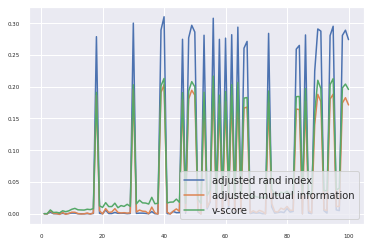

In [213]:
adjrand_scores_knn = []
adjmutual_scores_knn = []
v_scores_knn = []
for k in range(1, 101):
    km = KMeans(k, random_state = 99).fit(X)
    adjrand_scores_knn.append(metrics.adjusted_rand_score(km.labels_, labels_true))
    adjmutual_scores_knn.append(metrics.adjusted_mutual_info_score(km.labels_, labels_true))
    v_scores_knn.append(metrics.v_measure_score(km.labels_, labels_true))
    
plots(adjrand_scores_knn, adjmutual_scores_knn, v_scores_knn, 1, 101)

In [214]:
start_time = time.time()
km = KMeans(39, random_state = 99).fit(X)
print("--- %s seconds ---" % (time.time() - start_time))
print('knn adjusted rand score for {} clusters is : {} ' .format(n_clusters, metrics.adjusted_rand_score(km.labels_, labels_true)))
print('knn adjusted mutual information score for {} clusters is : {} ' .format(n_clusters, metrics.adjusted_mutual_info_score(km.labels_, labels_true)))
print('knn v-measure score for {} clusters is : {} ' .format(n_clusters, metrics.v_measure_score(km.labels_, labels_true)))

--- 2.9896280765533447 seconds ---
knn adjusted rand score for 2 clusters is : 0.28928018819219603 
knn adjusted mutual information score for 2 clusters is : 0.190885749940728 
knn v-measure score for 2 clusters is : 0.20149714359556398 


- HAC single

In [220]:
start_time = time.time()
hac_single = fastcluster.linkage(X, method = 'single')
print("--- %s seconds ---" % (time.time() - start_time))
hac_labels_single =  fcluster(hac_single, n_clusters, criterion='maxclust')-1
print('hac adjusted rand score for {} clusters is : {} ' .format(n_clusters, metrics.adjusted_rand_score(hac_labels_single, labels_true)))
print('hac adjusted mutual information score for {} clusters is : {} ' .format(n_clusters, metrics.adjusted_mutual_info_score(hac_labels_single, labels_true)))
print('hac v-measure score for {} clusters is : {} ' .format(n_clusters, metrics.v_measure_score(hac_labels_single, labels_true)))

--- 0.5276758670806885 seconds ---
hac adjusted rand score for 2 clusters is : 0.0 
hac adjusted mutual information score for 2 clusters is : 2.374820230328942e-16 
hac v-measure score for 2 clusters is : 0.0009710074111617752 


- HAC average

In [216]:
start_time = time.time()
hac_avg = fastcluster.linkage(X, method = 'average')
print("--- %s seconds ---" % (time.time() - start_time))
hac_labels_avg =  fcluster(hac_avg, n_clusters, criterion='maxclust')-1
print('hac adjusted rand score for {} clusters is : {} ' .format(n_clusters, metrics.adjusted_rand_score(hac_labels_avg, labels_true)))
print('hac adjusted mutual information score for {} clusters is : {} ' .format(n_clusters, metrics.adjusted_mutual_info_score(hac_labels_avg, labels_true)))
print('hac v-measure score for {} clusters is : {} ' .format(n_clusters, metrics.v_measure_score(hac_labels_avg, labels_true)))

--- 0.5034661293029785 seconds ---
hac adjusted rand score for 2 clusters is : 0.0 
hac adjusted mutual information score for 2 clusters is : 2.374820230328942e-16 
hac v-measure score for 2 clusters is : 0.0009710074111617752 


- HAC complete

In [217]:
start_time = time.time()
hac_com = fastcluster.linkage(X, method = 'complete')
print("--- %s seconds ---" % (time.time() - start_time))
hac_labels_com =  fcluster(hac_com, n_clusters, criterion='maxclust')-1
print('hac adjusted rand score for {} clusters is : {} ' .format(n_clusters, metrics.adjusted_rand_score(hac_labels_com, labels_true)))
print('hac adjusted mutual information score for {} clusters is : {} ' .format(n_clusters, metrics.adjusted_mutual_info_score(hac_labels_com, labels_true)))
print('hac v-measure score for {} clusters is : {} ' .format(n_clusters, metrics.v_measure_score(hac_labels_com, labels_true)))

--- 0.5847151279449463 seconds ---
hac adjusted rand score for 2 clusters is : -3.8053976002757408e-06 
hac adjusted mutual information score for 2 clusters is : -0.0006600790780446663 
hac v-measure score for 2 clusters is : 0.00013875960697098057 


- HAC ward

In [218]:
start_time = time.time()
hac_ward = fastcluster.linkage(X, method = 'ward')
print("--- %s seconds ---" % (time.time() - start_time))
hac_labels_ward =  fcluster(hac_ward, n_clusters, criterion='maxclust')-1
print('hac adjusted rand score for {} clusters is : {} ' .format(n_clusters, metrics.adjusted_rand_score(hac_labels_ward, labels_true)))
print('hac adjusted mutual information score for {} clusters is : {} ' .format(n_clusters, metrics.adjusted_mutual_info_score(hac_labels_ward, labels_true)))
print('hac v-measure score for {} clusters is : {} ' .format(n_clusters, metrics.v_measure_score(hac_labels_ward, labels_true)))

--- 0.688788890838623 seconds ---
hac adjusted rand score for 2 clusters is : -1.9045587438425408e-06 
hac adjusted mutual information score for 2 clusters is : -0.0006623526285103298 
hac v-measure score for 2 clusters is : 0.00023595959948222636 


In [221]:
#single link
adjrand_scores_single = []
adjmutual_scores_single = []
v_scores_single = []

#average link
adjrand_scores_avg = []
adjmutual_scores_avg = []
v_scores_avg = []

#complete link
adjrand_scores_com = []
adjmutual_scores_com = []
v_scores_com = []

#ward link
adjrand_scores_ward = []
adjmutual_scores_ward = []
v_scores_ward = []

for k in range(1, 101):
    #single link
    hac_single = fastcluster.linkage(X, method = 'single')
    hac_labels_single =  fcluster(hac_single, k, criterion='maxclust')
    adjrand_scores_single.append(metrics.adjusted_rand_score(hac_labels_single-1, labels_true))
    adjmutual_scores_single.append(metrics.adjusted_mutual_info_score(hac_labels_single-1, labels_true))
    v_scores_single.append(metrics.v_measure_score(hac_labels_single-1, labels_true))
    
    #average link
    hac_avg = fastcluster.linkage(X, method = 'average')
    hac_labels_avg =  fcluster(hac_avg, k, criterion='maxclust')
    adjrand_scores_avg.append(metrics.adjusted_rand_score(hac_labels_avg-1, labels_true))
    adjmutual_scores_avg.append(metrics.adjusted_mutual_info_score(hac_labels_avg-1, labels_true))
    v_scores_avg.append(metrics.v_measure_score(hac_labels_avg-1, labels_true))
    
    #complete link
    hac_com = fastcluster.linkage(X, method = 'complete')
    hac_labels_com =  fcluster(hac_com, k, criterion='maxclust')
    adjrand_scores_com.append(metrics.adjusted_rand_score(hac_labels_com-1, labels_true))
    adjmutual_scores_com.append(metrics.adjusted_mutual_info_score(hac_labels_com-1, labels_true))
    v_scores_com.append(metrics.v_measure_score(hac_labels_com-1, labels_true))
    
    
    #ward link
    hac_ward = fastcluster.linkage(X, method = 'ward')
    hac_labels_ward =  fcluster(hac_ward, k, criterion='maxclust')
    adjrand_scores_ward.append(metrics.adjusted_rand_score(hac_labels_ward-1, labels_true))
    adjmutual_scores_ward.append(metrics.adjusted_mutual_info_score(hac_labels_ward-1, labels_true))
    v_scores_ward.append(metrics.v_measure_score(hac_labels_ward-1, labels_true))

Single link
best adjusted rand score is 2.6748037282391698e-05 for k : 92
best adjusted mutual info score is 1.3764266461971293e-05 for k : 92
best v-measure score is 0.06046103779649688 for k : 99


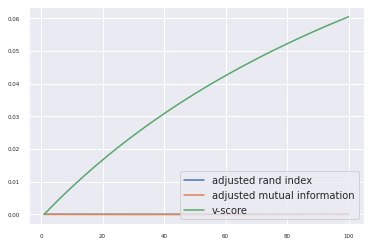


Average link
best adjusted rand score is 1.5345843060270594e-05 for k : 93
best adjusted mutual info score is 7.87358594383398e-06 for k : 93
best v-measure score is 0.06046103779649688 for k : 99


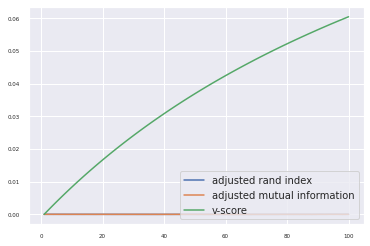


Complete link
best adjusted rand score is 0.0 for k : 0
best adjusted mutual info score is 0.0010912735753875408 for k : 71
best v-measure score is 0.03857625143443414 for k : 93


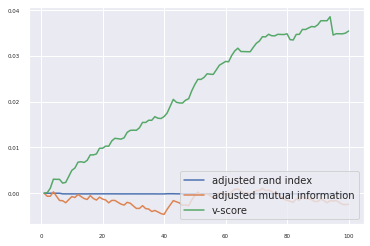


Ward link
best adjusted rand score is 0.0002886231401989602 for k : 87
best adjusted mutual info score is 0.0026812494381569184 for k : 83
best v-measure score is 0.032141456411965356 for k : 97


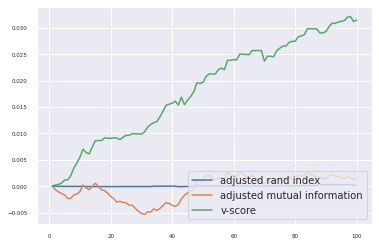

In [222]:
print('Single link')
plots(adjrand_scores_single, adjmutual_scores_single, v_scores_single, 1, 101)

print()
print('Average link')
plots(adjrand_scores_avg, adjmutual_scores_avg, v_scores_avg, 1, 101)

print()
print('Complete link')
plots(adjrand_scores_com, adjmutual_scores_com, v_scores_com, 1, 101)

print()
print('Ward link')
plots(adjrand_scores_ward, adjmutual_scores_ward, v_scores_ward, 1, 101)

- GMM

In [223]:
start_time = time.time()
gmm = GaussianMixture(n_components = n_clusters).fit(X)
print("--- %s seconds ---" % (time.time() - start_time))
gmm_labels = gmm.predict(X)
print('gmm adjusted rand score for {} clusters is : {} ' .format(n_clusters, metrics.adjusted_rand_score(gmm_labels, labels_true)))
print('gmm adjusted mutual information score for {} clusters is : {} ' .format(n_clusters, metrics.adjusted_mutual_info_score(gmm_labels, labels_true)))
print('gmm v-measure score for {} clusters is : {} ' .format(n_clusters, metrics.v_measure_score(gmm_labels, labels_true)))

--- 0.1809864044189453 seconds ---
gmm adjusted rand score for 2 clusters is : 0.0 
gmm adjusted mutual information score for 2 clusters is : 2.3732639916458956e-16 
gmm v-measure score for 2 clusters is : 0.0009710074111617752 


best adjusted rand score is 0.0034998810687987903 for k : 36
best adjusted mutual info score is 0.007705979716843551 for k : 36
best v-measure score is 0.05081310339195035 for k : 76


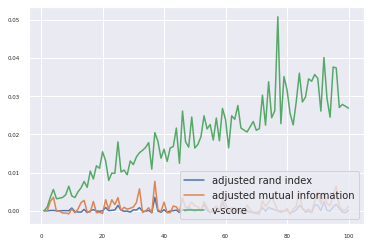

In [224]:
adjrand_scores_gmm = []
adjmutual_scores_gmm = []
v_scores_gmm = []
for k in range(1, 101):
    gmm = GaussianMixture(n_components = k).fit(X)
    gmm_labels = gmm.predict(X)
    adjrand_scores_gmm.append(metrics.adjusted_rand_score(gmm_labels, labels_true))
    adjmutual_scores_gmm.append(metrics.adjusted_mutual_info_score(gmm_labels, labels_true))
    v_scores_gmm.append(metrics.v_measure_score(gmm_labels, labels_true))
    
plots(adjrand_scores_gmm, adjmutual_scores_gmm, v_scores_gmm,1, 101)

The score for gmm is quite low even after some searching for the best number of components in the algorithm

- DBSCAN 

In [226]:
dbsc = DBSCAN().fit(X)
dbsc_labels = dbsc.labels_

print('dbsc adjusted rand score for {} clusters is : {} ' .format(n_clusters, metrics.adjusted_rand_score(dbsc_labels, labels_true)))
print('dbsc adjusted mutual information score for {} clusters is : {} ' .format(n_clusters, metrics.adjusted_mutual_info_score(dbsc_labels, labels_true)))
print('dbsc v-measure score for {} clusters is : {} ' .format(n_clusters, metrics.v_measure_score(dbsc_labels, labels_true)))

dbsc adjusted rand score for 2 clusters is : 0.0 
dbsc adjusted mutual information score for 2 clusters is : 0.0 
dbsc v-measure score for 2 clusters is : 0.0 


- HDBSCAN 

In [211]:
start_time = time.time()
hdbscn = hdbscan.HDBSCAN()
hdbsc_labels = hdbscn.fit_predict(X)
print("--- %s seconds ---" % (time.time() - start_time))
print('hdbsc adjusted rand score for {} clusters is : {} ' .format(n_clusters, metrics.adjusted_rand_score(hdbsc_labels, labels_true)))
print('hdbsc adjusted mutual information score for {} clusters is : {} ' .format(n_clusters, metrics.adjusted_mutual_info_score(hdbsc_labels, labels_true)))
print('hdbsc v-measure score for {} clusters is : {} ' .format(n_clusters, metrics.v_measure_score(hdbsc_labels, labels_true)))

--- 2.172253131866455 seconds ---
hdbsc adjusted rand score for 2 clusters is : 0.005891865548363464 
hdbsc adjusted mutual information score for 2 clusters is : 0.10466621783903529 
hdbsc v-measure score for 2 clusters is : 0.10552899438990096 


- SOM

In [212]:
start_time = time.time()
som = SOM(m=n_clusters, n=1, dim=len(X[0]))
som.fit(X)
print("--- %s seconds ---" % (time.time() - start_time))
som_labels = som.predict(X)
print('som adjusted rand score for {} clusters is : {} ' .format(n_clusters, metrics.adjusted_rand_score(som_labels, labels_true)))
print('som adjusted mutual information score for {} clusters is : {} ' .format(n_clusters, metrics.adjusted_mutual_info_score(som_labels, labels_true)))
print('som v-measure score for {} clusters is : {} ' .format(n_clusters, metrics.v_measure_score(som_labels, labels_true)))

--- 1.4959101676940918 seconds ---
som adjusted rand score for 2 clusters is : 0.003413892066122916 
som adjusted mutual information score for 2 clusters is : 0.003553779067334636 
som v-measure score for 2 clusters is : 0.003939608351316033 


- Markdown table

|                | Adjusted Rand Index | Adjusted Mutual Information | V-measure | Time (seconds) |
|----------------|---------------------|-----------------------------|-----------| -----|
| K-Means        | -0.00017906843635825026              | 9.314131320958246e-05                      | 0.5053680248632945    |   0.2545902729034424   |
| HAC 'Single'   | 0.0              | 2.374820230328942e-16                      | 0.0009710074111617752    |   0.5276758670806885   | 
| HAC 'Average'  | 0.0              | 2.374820230328942e-16                       | 0.0009710074111617752    |   0.5034661293029785    |
| HAC 'Complete' | -3.8053976002757408e-06              | -0.0006600790780446663                      | 00.00013875960697098057    |    0.5847151279449463 seconds   |
| HAC 'Ward'     | -1.9045587438425408e-06              |-0.0006623526285103298                      | 0.00023595959948222636    |  0.688788890838623    |
| GMM            | 0.0              | 2.3732639916458956e-16                      | 0.0009710074111617752    |  0.1809864044189453    |
| DBSCAN         | 0.0             | 0.0                  | 0.0   |    0.3   |
| HDBSCAN        | 0.005891865548363464              | 0.10466621783903529                      |0.10552899438990096    |   2.172253131866455   |
| SOM            | 0.003413892066122916              | 0.003553779067334636                      | 0.003939608351316033    |   1.4959101676940918   |

We observe that the results of the algorithms used in the big dataset that has more tha one dimensions are quit disappointing. The best scores are achieved in HBDSCAN model and the SOM. The rest of the algorithms seed to need some grid search in their parameters in order to perform better. 